In [ ]:
!git clone https://github.com/wolfromanlist/MLForEngineers.git
%cd MLForEngineers/Notebooks/

# Notebook 5: Neural Networks Part 2

## Überblick

Im letzten Notebook haben wir alle theoretischen Grundlagen kennengelernt, um ein eigenes Single-Layer Perzeptron (SLP) zu bauen. In diesem Notebook setzen wir dieses Wissen in die Praxis um.
Anhand eines konkreten Beispiels werden wir sämtliche Komponenten – von der Aktivierungsfunktion bis zur Trainingsschleife – selbst implementieren und dabei sehen: Die Umsetzung ist gar nicht so kompliziert.
Anschließend lösen wir dasselbe Problem mithilfe von TensorFlow und vergleichen, wie viel einfacher und schneller sich neuronale Netze mit professionellen Libraries aufsetzen lassen.
Los geht’s mit einer kurzen Einführung in unser Beispielproblem!

### **Das Problem: Automatische Analyse zyklischer Bewegungen mit einem Single-Layer Perceptron**  

In unserer Forschungsgruppe untersuchen wir die mechanische Belastbarkeit von Steckverbindungen. Um die Haltbarkeit unter realistischen Bedingungen zu testen, werden die Steckverbinder in einem speziellen Testinstrument wiederholt belastet – ein Prozess, der sich als periodische Bewegung erfassen lässt.  

Unsere amerikanischen Kooperationspartner haben uns im Rahmen einer Replikationsstudie Messdaten übermittelt, die die zyklische Bewegung des Testinstruments dokumentieren. Die Daten liegen im CSV-Format vor und enthalten die Spalten **Testeinheit**, **Zeit** und **Position**. So weit, so gut – aber es gibt zwei Herausforderungen:  

1. **Unvollständige Daten:**
    - Unsere amerikanischen Freunde hatten wohl einen Softwarefehler, wodurch die letzten Sekunden der Positionsmessung nicht mehr aufgezeichnet wurden.
2. **Fehlende Parameter:**
    - Die Daten lassen sich als Sinusfunktion $p(t) = A \sin(\omega t + \phi) + c $ beschreiben.  
    - Die Amplitude $A$ und den Positions-Offset $C$ haben uns unsere Kollegen mitgeteilt. 
    - Die **Frequenz** $\omega$  (die Geschwindigkeit der Bewegung) und die **Phase** $\phi$ (die zeitliche Verschiebung) sind jedoch nicht bekannt und aus den unvollständigen Daten nicht direkt ablesbar.  

Wie es sich für eine echte transatlantische Kooperation gehört, wurden die Daten natürlich auch in imperialen Einheiten geliefert, aber angesichts der herannahenden Deadline für unser Paper bleibt uns nichts anderes übrig als mit den gegebenen Daten zu arbeiten.  

Anstatt nun Frequenz und Phase per Hand zu schätzen oder umständlich mit einer Stoppuhr zu analysieren, lassen wir einfach unser Single-Layer Perceptron (SLP) diese Aufgabe übernehmen!  

**Ziel:** Wir trainieren ein SLP, das die gemessene Bewegung als Sinusfunktion $p(t)$ modelliert und dabei automatisch die Parameter $\omega$ (Frequenz) und $\phi$ (Phase) bestimmt.  

Dazu werden wir zuerst alle notwendigen Funktionen selbst implementieren – von der Aktivierungsfunktion bis zum Gradientenabstieg. Anschließend vergleichen wir unsere Lösung mit einer Implementierung in **TensorFlow**, um zu sehen, wie sich unser manuell gebautes neuronales Netz im Vergleich zu modernen Machine-Learning-Frameworks schlägt.  

Also: Lassen wir das SLP für uns arbeiten und schicken wir unseren amerikanischen Kollegen ein paar metrische Einheiten zurück! 😉

### Daten einlesen und inspizieren
Um uns einen Überblick über die Struktur der Daten zu verschaffen, importieren wir sie zunächst und schauen uns die ersten Zeilen an.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_file = '../Data/unit_test_data.csv'

# Daten als dataframe importieren
df = pd.read_csv(csv_file)

# Daten inspizieren
print(df.head(20))

    Test Unit  Time   Position
0          11   1.0   7.965156
1          11   2.0   9.677114
2          11   3.0  12.378327
3          11   4.0  15.786283
4          11   5.0  18.760037
5          11   6.0  20.554457
6          11   7.0  20.851844
7          11   8.0  19.336893
8          11   9.0  16.549622
9          19   1.0   8.290902
10         19   2.0   9.737160
11         19   3.0  12.449544
12         19   4.0  15.770774
13         19   5.0  18.904937
14         19   6.0  20.611317
15         19   7.0  20.971045
16         19   8.0  19.394942
17         19   9.0  16.519252
18       1022   1.0   8.141988
19       1022   2.0   9.642068


Das Datenformat scheint zu stimmen. Wir haben eine Spalte mit der ID der Testeinheit und wir haben neun Zeit-Positions-Paare pro Einheit. Schauen wir eben, wie die Daten grafisch aussehen.

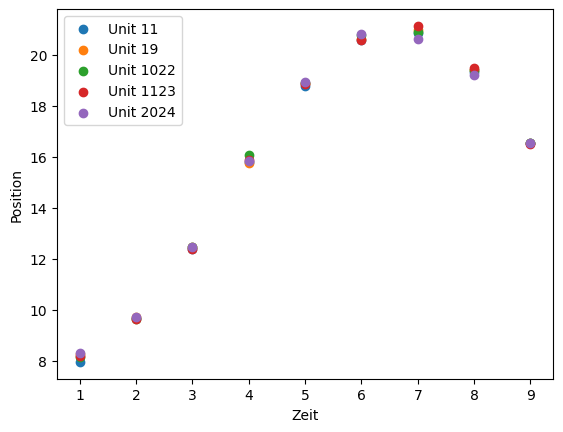

In [3]:
# Daten nach Testeinheit gruppieren
grouped = df.groupby('Test Unit')

# Rohdaten nach Testeinheit plotten
for unit, group in grouped:
    plt.scatter(group['Time'], group['Position'], label=f'Unit {unit}')
plt.xlabel('Zeit')
plt.ylabel('Position')
plt.legend()
plt.show()

Okay, die Daten sind unter den Testeinheiten sehr ähnlich. Die Experimente waren also sehr konsistent, obwohl ein gutes Stück der Sinuskurve fehlt. Um eine bessere Schätzung der Parameter $\omega$ und $\phi$ zu bekommen, sollten wir den Durchschnitt über alle Einheiten und Testläufe bilden, damit wir die Schwankungen reduzieren.

In [4]:
# Wir nehmen den Durchschnitt der Position (...['Position'].mean()) über die verschiedenen Messreihen für jeden Zeitpunkt separat (groupby Time)
data = df.groupby('Time', as_index=False)['Position'].mean() # Durchschnittliche Position pro Zeitwert berechnen
print(data.head(9))

   Time   Position
0   1.0   8.184020
1   2.0   9.687349
2   3.0  12.433554
3   4.0  15.863667
4   5.0  18.864524
5   6.0  20.657872
6   7.0  20.886062
7   8.0  19.357744
8   9.0  16.537589


Nun plotten wir die so erhaltenen Daten:

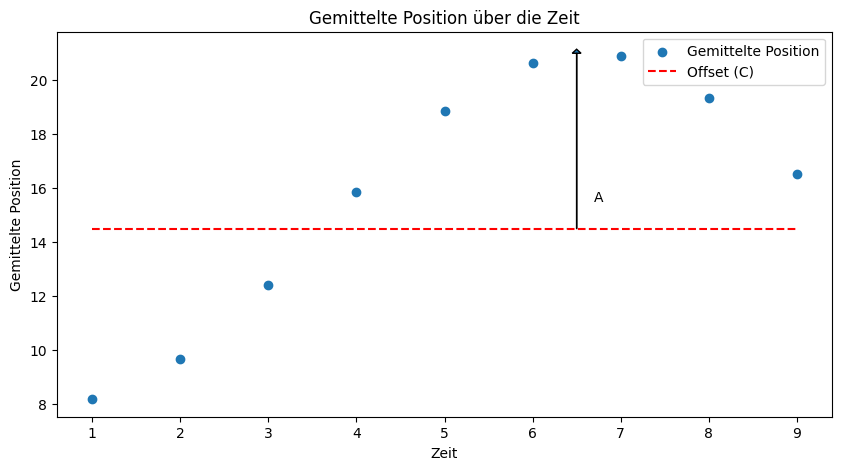

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

# Gemittelte Position über Zeit
ax.scatter(data['Time'], data['Position'], label='Gemittelte Position')

# Parameter: Amplitude (A) und Offset (C)
A = 6.5
C = 14.5

# Offset als gestrichelte Linie
ax.plot([data['Time'].iloc[0], data['Time'].iloc[-1]], [C, C], 'r--', label='Offset (C)')

# Amplitude als Pfeil darstellen
ax.arrow(6.5, C, 0, A, head_width=0.1)
ax.annotate('A', xy=(6.7, C + 1))

ax.set_xlabel('Zeit')
ax.set_ylabel('Gemittelte Position')
ax.set_title('Gemittelte Position über die Zeit')
plt.legend()
plt.show()

### Standardisieren der Daten

Um einen möglichst effizienten Trainingsprozess zu erreichen, sollten wir die Daten standardisieren. Wenn wir uns an die Datenverarbeitung zurückerinnern, bestand die Standardisierung aus der Normierung der Daten und einer Verschiebung, sodass die Daten um 0 zentriert sind und eine Varianz von 1 haben:

$$
Z = \frac{X - \mu}{\sigma}
$$

Wobei:
- $X$ unsere Variablen sind,
- $\mu$ der Mittelwert der Variablen ist,
- $\sigma$ die Standardabweichung der Variablen ist.

In [6]:
# Zu standardisierende Spalten
columns_to_standardize = ['Time', 'Position']

# Standardisierung der Daten
data_s = (data[columns_to_standardize] - data[columns_to_standardize].mean()) / data[columns_to_standardize].std()

# Auch A und C müssen entsprechend skaliert werden
A_s = A / data['Position'].std()
C_s = (C - data['Position'].mean()) / data['Position'].std()

Betrachten wir nun die Standardisierten Daten. Wir erwarten, dass sie in der Verteilung den Originaldaten ähneln, aber die Spannweite kleiner und um 0 zentriert ist.

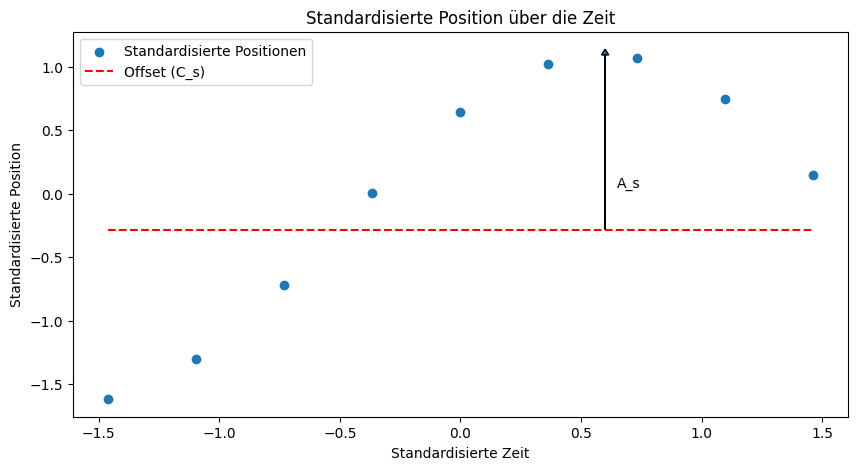

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

# Standardisierte Datenpunkte
ax.scatter(data_s['Time'], data_s['Position'], label='Standardisierte Positionen')

# Offset C (standardisiert)
ax.plot([data_s['Time'].iloc[0], data_s['Time'].iloc[-1]], [C_s, C_s], 'r--', label='Offset (C_s)')

# Amplitude A (standardisiert) als Pfeil
ax.arrow(0.6, C_s, 0, A_s, head_width=0.03)
ax.annotate('A_s', xy=(0.65, C_s + 1 / 3))

ax.set_xlabel('Standardisierte Zeit')
ax.set_ylabel('Standardisierte Position')
ax.set_title('Standardisierte Position über die Zeit')
plt.legend()
plt.show()

Okay, unsere Daten sind bereit und jetzt können wir den Bau des SLPs beginnen! Bevor wir aber loslegen, fassen wir noch einmal kurz die Schritte zusammen, die ein Single-Layer Perzeptron bei der Vorhersage und beim Lernen durchläuft. Zunächst haben wir den Forward-Pass, vom Input zum ersten Output. Der Forward-Pass ist so aufgebaut:

- Wir nehmen Inputs $x$ an
- Gewichten sie nach $z = W \cdot x + b$
- Wenden unsere Aktivierungsfunktion $f(z)$ an und
- Machen unsere erste Vorhersage $y$

Dann kommt der Backward-Pass mit dem Ziel, die Parameter zu verbessern. Er sieht so aus:

- Wir bestimmen den Loss $\mathcal{L} = \frac{1}{2N}\sum_{i=1}^N (\hat{y}_i - y_i)^2$
- Wir bestimmen die Änderung des Loss bezüglich unserer Parameter $\nabla \mathcal{L} = \begin{pmatrix} \frac{\partial \mathcal{L}}{\partial W} & \frac{\partial \mathcal{L}}{\partial b} \end{pmatrix}^\top$
- Aktualisieren unsere Parameter nach der Update-Regel $\begin{pmatrix} W_{\mathrm{neu}} & b_\mathrm{neu}\end{pmatrix} = \begin{pmatrix} W_\mathrm{alt} & b_\mathrm{alt}\end{pmatrix} - \eta \nabla \mathcal{L}^\top$ und
- fangen von vorne an.

Grafisch sieht das Ganze so aus:

<center><img src="../Images/FwdBckwdPass.png" width="570" height="280"></center>

An diesem Schema werden wir uns nun Schritt für Schritt orientieren und die einzelnen Funktionen selber schreiben. Bevor wir das aber tun, eine kurze Anmerkung zu dem Forward Pass:
Das Resultat des Forward Pass ist die Vorhersage $\hat{y}$, die wie in der Grafik oben einfach aus der Aktivierungsfunktion $f$ angewandt auf die Gewichtung $z$ bestehen kann, also $\hat{y} = f(z)$. Allerdings können wir die Vorhersage noch beliebig modifizieren. Wir könnten also definieren: $\hat{y} = f(z) + 3$. Solange wir den Gradienten von $\mathcal{L}$ richtig bestimmen, funktioniert der Gradient Descent Algorithmus wie gehabt. Im Allgemeinen erstellt man also zwei Funktionen: Die Aktivierungsfunktion $f$ und den Forward Pass (mit $\hat{y}$ als Ausgabe), wo die Aktivierungsfunktion noch weiter verändert werden kann. Das dient dazu, dass man die Aktivierungsfunktion dann einfach nach Belieben austauschen kann und den finalen Output an anderer Stelle beliebig modifizieren kann. 


Konkret an unserem Beispiel: Wir haben Daten der Form $A \sin(\omega t + \phi) + C$, wo $A$ und $C$ bekannt sind. Da unsere Funktion periodisch ist, bietet sich für uns der Sinus als Aktivierungsfunktion an. Eine lineare Aktivierungsfunktion wäre für diesen Fall wirklich nicht optimal (aber das könnt ihr selbst später ausprobieren). Allerdings bringt uns auch ein Sinus nicht sonderlich weit, da er nur Werte zwischen -1 und 1 annimmt. Wir müssen ihn also um $C$ verschieben und mit $A$ skalieren, um sinnvolle Vorhersagen zu treffen. Das machen wir dann in einer eigenen Funktion `forward_pass`, damit wir die (austauschbare) Aktivierungsfunktion klar getrennt haben und bei Bedarf einfach ändern können (z.B. könnte der Kosinus auch eine geeignete Aktivierungsfunktion sein).

### Aktivierungsfunktion definieren
Wie versprochen erstellen wir nun die Aktivierungsfunktion. Aufgrund der periodischen Natur der Daten und der zyklischen Bewegung, die sie beschreiben, bietet sich der Sinus als Aktivierungsfunktion gut an. Da die Gewichtung immer erfolgt, wenn wir die Aktivierungsfunktion ausführen, definieren wir direkt beides in der gleichen Funktion. 

In [8]:
def activation(W, b, t):
    z = W * t + b       # 1. Gewichtung
    y = np.sin(z)       # 2. Anwendung der Aktivierungsfunktion (Sinus)
    return y

## Forward Pass
Nun kommt die Verschiebung und Skalierung um die von unseren Kollegen übermittelten Parameter $C$ und $A$. Dies stellt unseren finalen Output $\hat{y}$ dar und damit das Endergebnis des Forward Pass (daher auch der Name der Funktion).

In [9]:
def forward_SLP(W, b, t, A, C):
    """
    Berechnet die Vorhersage y_hat aus gegebenen Parametern (A, C) und der Aktivierungsfunktion.
    """
    y_hat = A * activation(W, b, t) + C
    return y_hat

Das folgende GIF veranschaulicht noch einmal alle Schritte, die wir vom Input bis zu unserer Vorhersage durchlaufen.

<center><img src="../Images/InterpolationScene_ManimCE_v0.19.0.gif" width="600" height="400"></center>

Wichtig ist es hier zu erkennen, dass die Parameter $\omega$ und $\phi$ hier unseren lernbaren Parametern $W$ und $b$ entsprechen, da sie unsere Sinuskurve in Phase und Periode verändern. $A$ und $C$ sind fixe Parameter, von dessen Richtigkeit wir bereits durch unsere Kollegen wissen und die wir also nicht mehr anpassen müssen.

### Gewichte Initialisieren
Nun haben wir alle Funktionalitäten aus dem Forward Pass implementiert. Um erste Vorhersagen treffen zu können, benötigen wir nur noch die Startparameter $W_0$ und $b_0$. Wir müssen also eine Funktion schreiben, die unsere Startparameter initialisiert. Die Gewichte können theoretisch jeden Wert annehmen, allerdings ist es üblich die Anfangsgewichte zwischen 0 und 1 zu initialisieren.

In [10]:
def init_weights(seed = 42):
    np.random.seed(seed) # Seed für Reproduzierbarkeit
    W = np.random.uniform(size=(1,))
    b = np.random.uniform(size=(1,))
    return W, b

## Backward Pass
Nachdem wir den Forward Pass abgeschlossen haben, widmen wir uns nun dem Backward Pass.

### Verlustfunktion (Loss)
Da es sich um ein Regressionsproblem handelt, verwenden wir wieder die mittlere quadratische Abweichung (engl. Mean Squared Error, MSE). Diese misst die durchschnittliche Abweichung der Vorhersage von den tatsächlichen Werten.

Die Formel lautet:
$$
\mathcal{L} = \frac{1}{2N} \sum_{i=1}^N (\hat{y}_i - y_i)^2
$$
Der Faktor $\frac{1}{2}$ wird aus mathematischen Gründen eingeführt, da er sich beim Ableiten der Funktion wegkürzt.


In [11]:
def mse_loss(y_pred, y_true):
    return 1/2 * np.mean((y_pred - y_true) ** 2)

### Gradienten
Nun kommen wir zu dem Teil, der am besten verdeutlicht, warum niemand ein neuronales Netz manuell schreibt (wie wir es gerade tun), sondern vorgefertigte Bibliotheken verwendet: Die Gradienten. Der große Nachteil der manuellen Implementierung ist, dass man die Gradienten der Verlustfunktion nach den Parametern einfach selbst ausrechnen muss. Das kann abhängig von der Komplexität der Funktionen und der Dimensionen der Inputs und Outputs schnell unübersichtlich werden. Auch die Herleitung unserer spezifischen Gradienten von $\mathcal{L}$ ist etwas zu lang (und langweilig), um sie hier zu zeigen – wir geben die Ergebnisse direkt an. Wer möchte, kann sie gerne nachrechnen:

$$
\frac{\partial \mathcal{L}}{\partial W} = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i) A \cos \left(Wt_i+b\right) t_i \\
\frac{\partial \mathcal{L}}{\partial b} = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i) A \cos \left(Wt_i+b\right) 
$$

In [12]:
def compute_gradients(W, b, t, p_true, A, C):
    p_pred = forward_SLP(W, b, t, A, C)
    error = p_pred - p_true
    dL_dW = np.mean(error * A * np.cos(W * t + b) * t)
    dL_db = np.mean(error * A * np.cos(W * t + b))
    return dL_dW, dL_db

### Update-Regel
Fehlt nur noch das Aktualisieren der Parameter mithilfe unserer Update-Regel. Dafür benötigen wir nur die alten Parameter, die eben berechneten Gradienten und die Lernrate $\eta$.

In [13]:
def update_parameters(W, b, dL_dW, dL_db, eta):
    W_new = W - eta * dL_dW
    b_new = b - eta * dL_db
    return W_new, b_new

### Trainings-Loop

Wir haben alles beisammen, um den Trainings-Loop zu bauen. In diesem müssen wir nur den Forward Pass und den Backward Pass mit unseren bereits geschriebenen Funktionen nacheinander ausführen. Die Funktion `train_slp` nimmt alle dafür benötigten Werte an und trainiert unser SLP mit so vielen Schritten, wie wir durch die Variable `epochs` festlegen. Die Schritte, die dabei pro Iteration durchlaufen werden sind:

1. Forward Pass mit alten Parametern berechnen
2. Loss bestimmen
3. Gradienten bestimmen
4. Neue Parameter mit den Gradienten berechnen

In [14]:
def train_slp(x, y_true, W, b, A, C, eta, epochs):
    loss_history = []
    for epoch in range(epochs):
        # Forward Pass
        y_pred = forward_SLP(W, b, x, A, C)
        loss = mse_loss(y_pred, y_true)

        # Backward Pass
        dL_dW, dL_db = compute_gradients(W, b, x, y_true, A, C)
        W, b = update_parameters(W, b, dL_dW, dL_db, eta)

        # Aufzeichnen des Verlusts
        loss_history.append(loss)
        if epoch % 30 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, W_s: {W[0]:.4f}, b_s: {b[0]:.4f}')
    return W, b, loss_history

### **Das Training**
Jetzt kann es losgehen. Wir können unser SLP jetzt trainieren, indem wir alle benötigten Parameter definieren bzw. initialisieren und in die Funktion `train_SLP` geben. Wir sollten automatisch Feedback über den Loss-Wert sowie die aktuellen Parameter während des Trainingsprozesses erhalten. Los geht's!

Initiale Gewichte:  
 W_0:  [0.37454012] 
 b_0:  [0.95071431]
Epoch 0, Loss: 0.5403, W_s: 0.3820, b_s: 0.9432
Epoch 30, Loss: 0.2686, W_s: 0.5859, b_s: 0.7478
Epoch 60, Loss: 0.1470, W_s: 0.7288, b_s: 0.6275
Epoch 90, Loss: 0.1005, W_s: 0.8265, b_s: 0.5656
Epoch 120, Loss: 0.0795, W_s: 0.8999, b_s: 0.5388
Epoch 150, Loss: 0.0669, W_s: 0.9608, b_s: 0.5329
Epoch 180, Loss: 0.0568, W_s: 1.0151, b_s: 0.5395
Epoch 210, Loss: 0.0476, W_s: 1.0657, b_s: 0.5539
Epoch 240, Loss: 0.0387, W_s: 1.1136, b_s: 0.5727
Epoch 270, Loss: 0.0304, W_s: 1.1588, b_s: 0.5937
Epoch 300, Loss: 0.0230, W_s: 1.2008, b_s: 0.6150
Epoch 330, Loss: 0.0167, W_s: 1.2390, b_s: 0.6354
Epoch 360, Loss: 0.0117, W_s: 1.2729, b_s: 0.6538
Epoch 390, Loss: 0.0080, W_s: 1.3022, b_s: 0.6699
Epoch 420, Loss: 0.0053, W_s: 1.3270, b_s: 0.6833
Epoch 450, Loss: 0.0034, W_s: 1.3477, b_s: 0.6944
Epoch 480, Loss: 0.0022, W_s: 1.3647, b_s: 0.7032
Epoch 510, Loss: 0.0014, W_s: 1.3784, b_s: 0.7101
Epoch 540, Loss: 0.0009, W_s: 1.3895, b_s: 

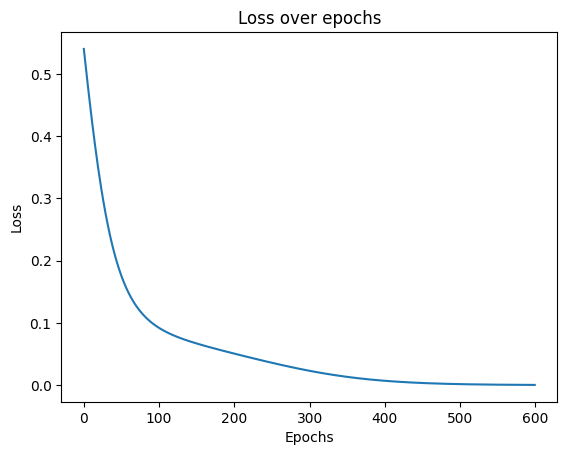

In [15]:
# Gewichte initialisieren
W_0, b_0 = init_weights()
print("Initiale Gewichte: ", "\n", "W_0: ", W_0,"\n" ,"b_0: ", b_0)

eta = 1e-2      # Lernrate festlegen
epochs = 600    # Anzahl der Epochen

# Training des SLP
W_s, b_s, loss_history = train_slp(data_s['Time'], data_s['Position'], W_0, b_0, A_s, C_s, eta, epochs)

# Plotten des Trainingsverlaufs
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.show()

### Ergebnisse
Die gute Nachricht: Unser Modell scheint zu lernen – der Verlustwert sinkt! Es ist nicht unüblich, dass man beim ersten Ausführen des Trainings-Loops einen steigenden Verlustwert sieht, weil man ein Vorzeichen verkehrt gesetzt hat, oder der Code gar nicht erst funktioniert. Aber: Nicht entmutigen lassen! Meist gibt es einen sehr einfachen (und leicht zu übersehenden Grund) dafür.
Wir wollen nun schauen, ob der sinkende Verlustwert tatsächlich bedeutet, dass unser SLP die Funktion gelernt hat. Dafür müssen wir die Daten (zunächst im Standardisierten Raum) plotten.

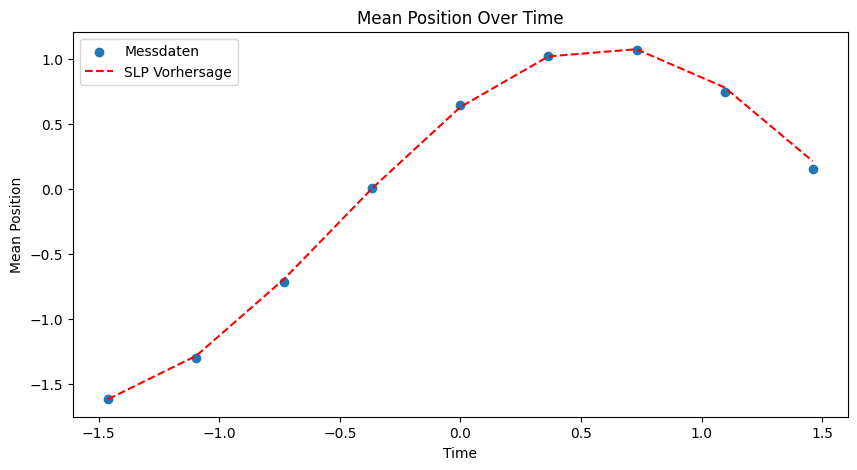

In [16]:
std_p = data['Position'].std()
std_t = data['Time'].std()

mean_p = data['Position'].mean()
mean_t = data['Time'].mean()

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(data_s['Time'], data_s['Position'], label='Messdaten')
ax.plot(data_s['Time'], forward_SLP(W_s, b_s, data_s['Time'], A_s, C_s), 'r--', label='SLP Vorhersage')
ax.set_xlabel('Time')
ax.set_ylabel('Mean Position')
ax.set_title('Mean Position Over Time')
plt.legend()
plt.show()

Zum Vergleich ist hier noch einmal der gleiche Plot mit der ersten Vorhersage (also den Gewichten $W_0$ und $b_0$). Wir sehen, dass die initiale Vorhersage (gepunktete Linie) deutlich von den Daten abweicht, während die trainierte Vorhersage (rote Linie) diese gut approximiert.

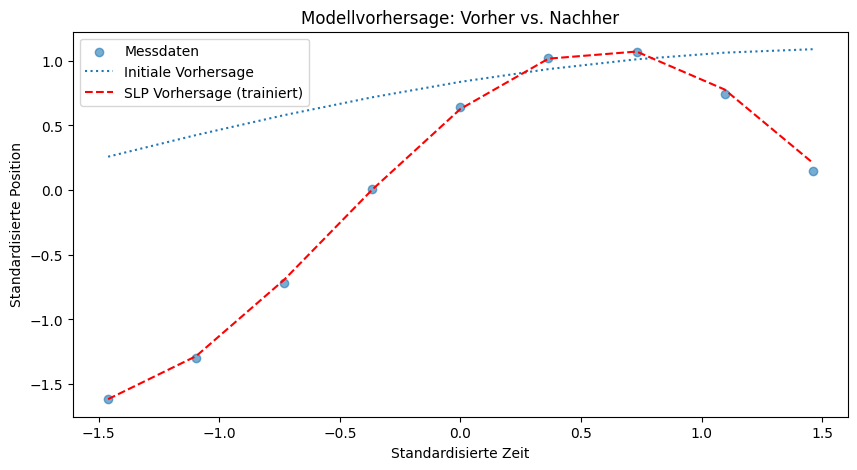

In [17]:
# Vergleich: Vorhersage vor und nach dem Training
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(data_s['Time'], data_s['Position'], label='Messdaten', alpha=0.6)

# Vorhersage mit initialen Gewichten
ax.plot(data_s['Time'], forward_SLP(W_0, b_0, data_s['Time'], A_s, C_s), linestyle='dotted', label='Initiale Vorhersage')

# Vorhersage mit gelernten Gewichten
ax.plot(data_s['Time'], forward_SLP(W_s, b_s, data_s['Time'], A_s, C_s), 'r--', label='SLP Vorhersage (trainiert)')

ax.set_xlabel('Standardisierte Zeit')
ax.set_ylabel('Standardisierte Position')
ax.set_title('Modellvorhersage: Vorher vs. Nachher')
ax.legend()
plt.show()

Das sieht wirklich gut aus! In dieser (standardisierten) Form sind die gelernten Parameter $W_{st} = \omega_{st}$ und $b_{st} = \phi_{st}$ allerdings nicht wirklich nützlich für uns. Wir müssen sie in den ursprünglichen Wertebereich zurücktransformieren. Wir haben soeben die Parameter für die Funktion $\sin\left(\omega_{st} t_{st} + \phi_{st}\right)$ der standardisierten Werte bestimmt. Wenn wir jetzt unsere Transformation einfügen $t_{st} = \frac{t - \mu}{\sigma}$, dann bekommen wir in den ursprünglichen Koordinaten $\sin\left(\frac{\omega_{st}t}{\sigma} + \phi_{st} - \frac{\omega_{st}\mu}{\sigma} \right)$. Wir wissen, dass das der Form $\sin \left(\omega t + \phi\right)$ entsprechen muss. Also haben wir:

$$
\begin{align}
\omega &= \frac{\omega_{st}}{\sigma} \\
\phi &= \phi_{st} - \frac{\omega_{st} \mu}{\sigma} = \phi_{st} - \omega \mu
\end{align}
$$

In [18]:
# Rücktransformation der gelernten Parameter
W = W_s / std_t
b = b_s - W * mean_t 

print(W, b/np.pi)

[0.5130989] [-0.58666366]


Die so bestimmten Parameter entsprechen also einer Frequenz von $W=  0.5 \, \mathrm{rad/s}$ und einem Phasenversatz von $b = -0.57 \pi \, \mathrm{rad}$. Damit ergibt sich eine Periode zu $T = \frac{2\pi \, \mathrm{rad}}{0.5 \, \mathrm{rad/s}} = 4 \pi \, \mathrm{s} = 12.56 \, \mathrm{s}$ und wir können nun die gesamte Kurve über eine ganze Periode plotten. Mit diesen Parametern können wir dann unsere Replikationsstudie durchführen und unsere Ergebnisse mit den Kollegen vergleichen.

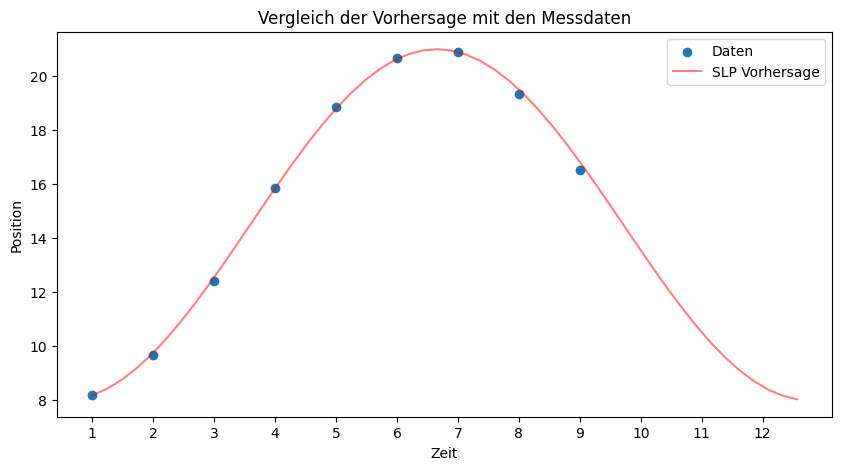

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(data['Time'], data['Position'], label='Daten')
ax.set_xticks(np.linspace(1, 12, 12))

ax.plot(np.linspace(1, 12.56, 50), forward_SLP(W, b, np.linspace(1, 12.56, 50), A, C), label='SLP Vorhersage', color='red', alpha=0.5)

ax.set_xlabel('Zeit')
ax.set_ylabel('Position')
ax.set_title('Vergleich der Vorhersage mit den Messdaten')
plt.legend()
plt.show()

### Fazit
Unser Single-Layer Perceptron hat also gelernt, eine nahezu vollständige Sinusfunktion zu rekonstruieren – und das, obwohl ein Teil der Daten gefehlt hat. Durch die Nutzung der bekannten Parameter $A$ und $C$, sowie gezieltes Training der verbleibenden Parameter $\omega$ und $\phi$, konnten wir die vollständige Bewegung vollständig modellieren.

Damit ist unser SLP nicht nur ein schönes Lernbeispiel für neuronale Netze – es hat auch eine echte Aufgabe im Rahmen einer Forschungskooperation gelöst!

---

## Implementierung in TensorFlow

Nachdem wir im letzten Abschnitt alle Teile eines neuronalen Netzes von Grund auf selbst implementiert haben – von der Aktivierungsfunktion über den Forward Pass bis hin zum Gradientenabstieg – stellt sich die logische Frage:

Geht das nicht einfacher?

Die Antwort ist: Ja, mit Bibliotheken wie TensorFlow (oder PyTorch).

### Was ist TensorFlow?

Erst einmal das Grundlegende: TensorFlow ist ein Open-Source-Framework für maschinelles Lernen, das von Google entwickelt wurde. Es ermöglicht die effiziente Umsetzung von KI- und Deep-Learning-Modellen – vom kleinen neuronalen Netz bis hin zu komplexen Produktionssystemen. 

Man kann TensorFlow entweder:

- auf niedriger Ebene verwenden (Gradientenberechnung per Hand, vollständige Kontrolle)
- oder auf hoher Abstraktionsebene arbeiten – mithilfe der sogenannten _Keras-API_, die sich wie ein Baukastensystem bedienen lässt.

Wir werden beide Ansätze miteinander kombinieren, um zu zeigen:

- wie TensorFlow im Innersten funktioniert,
- aber auch, wie viel einfacher (und sicherer!) das Training mit modernen Tools wird.

### Grundprinzip von TensorFlow

TensorFlow basiert – wie der Name vermuten lässt – auf dem Konzept der Tensoren, also mehrdimensionalen Arrays, die effizient auf CPU oder GPU verarbeitet werden. Jede Operation auf diesen Tensoren ist Teil eines berechenbaren Graphen, in dem TensorFlow automatisch (!) die Ableitungen berechnet, sogenannte _automatische Differenzierung_.

Im Prinzip bedeutet die Nutzung von TensorFlow direkt einige Vereinfachungen:

- **Automatische Gradientenberechnung** \
    Anstatt die Ableitungen der Verlustfunktion mühsam selbst zu berechnen, verwenden wir das `GradientTape` von TensorFlow. Es verfolgt automatisch, wie sich der Loss aus den Parametern ergibt, und berechnet die Gradienten für uns – unabhängig davon, wie komplex der Forward-Pass ist.
- **Zentrale Optimierungslogik** \
    Mit einem einzigen Aufruf (`optimizer.apply_gradients(...)`) werden die trainierbaren Parameter aktualisiert. Wir müssen keine eigene Update-Regel mehr implementieren.
- **Flexible Modellarchitektur** \
    Selbst wenn wir im aktuellen Fall unseren Forward-Pass noch selbst schreiben, erlaubt uns das sogenannte `Sequential`-Modell eine klare und modulare Struktur. Für gängige Netzwerke reicht meist eine Handvoll Zeilen Code.
- **Einbettung in ein großes Ökosystem** \
    TensorFlow bietet weit mehr als nur das Training von SLPs: Wir könnten dasselbe Modell in wenigen Zeilen als Klassifikator, CNN oder RNN umschreiben – mit GPU-Beschleunigung, Logging und Exportfunktionen.

Wir haben jetzt bereits viele Fachbegriffe genannt, aber keine Sorge: Wir werden alles noch einmal erklären.


### Unser Ziel
Wir wollen:

1. Dasselbe Problem wie zuvor lösen, diesmal aber mit TensorFlow.
2. Die Unterschiede verstehen – und den Komfortgewinn erleben.
3. Und sehen, wo man trotzdem noch eingreifen kann, wenn man will.

Also: Zeit, TensorFlow in Aktion zu sehen – los geht’s mit der Datenverarbeitung!

### Datenvorbereitung und Standardisierung

In der manuellen Version haben wir mit `NumPy` gearbeitet und unsere Daten standardisiert, um das Training effizienter zu gestalten. Auch in TensorFlow sollten wir nicht vergessen, die Daten zu normalisieren oder zu standardisieren. Das wirkt sich massiv auf Konvergenz und Stabilität des Trainings aus!

In unserem Fall standardisieren wir wieder Zeit- und Positionswerte wieder nach:

$$
Z = \frac{X - \mu}{\sigma}
$$

Dafür benutzen wir diesmal das uns bereits bekannte Vorgehen mit dem `StandardScaler` von `sklearn`.

In [20]:
# tensorflow und sklearn importieren
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Werte als NumPy-Arrays vorbereiten
t = df['Time'].values.reshape(-1,1).astype(np.float32)    
y = df['Position'].values.reshape(-1,1).astype(np.float32)

# Scaler initialisieren
scaler_t = StandardScaler()
scaler_y = StandardScaler()

# Daten standardisieren
t_scaled = scaler_t.fit_transform(t)
y_scaled = scaler_y.fit_transform(y)

/Users/romanlist/Python Projects/tensorvenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Auch wenn TensorFlow mit `NumPy`-Arrays arbeiten kann, ist es meist sinnvoll, direkt mit `tf.Tensor`-Objekten zu arbeiten. Wir müssen also die standardisierten Arrays in Tensoren umwandeln:



In [ ]:
# Tensorflow-Tensoren erzeugen
t_scaled_tf = tf.convert_to_tensor(t_scaled, dtype=tf.float32)
y_scaled_tf = tf.convert_to_tensor(y_scaled, dtype=tf.float32)

# Speichern der Mittelwerte und Standardabweichungen für Rücktransformation
mean_t, std_t = scaler_t.mean_[0], scaler_t.scale_[0]
mean_y, std_y = scaler_y.mean_[0], scaler_y.scale_[0]

# Auch unsere Parameter A und C müssen Tensoren sein
A = tf.convert_to_tensor(6.5, dtype=tf.float32)
C = tf.convert_to_tensor(14.5, dtype=tf.float32)

# Standardisierte Parameter
A_s = tf.convert_to_tensor(A_s, dtype=tf.float32)
C_s = tf.convert_to_tensor(C_s, dtype=tf.float32)

# Initialisierung der Gewichte
W_0, b_0 = init_weights()
W_0 = tf.convert_to_tensor(W_0, dtype=tf.float32)
b_0 = tf.convert_to_tensor(b_0, dtype=tf.float32)

### Modellarchitektur und Training mit TensorFlow

Unser Ziel ist es nun, das Single-Layer Perceptron (SLP) mithilfe von TensorFlow zu bauen. Auch wenn TensorFlow in der Lage ist, hochkomplexe Netzwerke mit vielen Schichten und Millionen von Parametern zu trainieren, ist unser SLP ganz einfach gestrickt: es hat nur eine Schicht und ein Neuron. Genau das bedeutet ja _Single-Layer Perzeptron_. Um es zu bauen, müssen wir die Begriffe `Sequential`-Modell und `Dense`-Layer zunächst definieren.

#### Das `Sequential`-Modell und `Dense`-Layers in TensorFlow

In TensorFlow werden neuronale Netzwerke häufig mit der sogenannten `Sequential`-API gebaut. Ein `Sequential`-Modell besteht – wie der Name schon sagt – aus einer _Abfolge_ (Sequence) von Schichten (Layers), bei denen der Output der einen Schicht direkt als Input an die nächste weitergegeben wird.
Die wichtigste Baustein-Schicht dabei ist die sogenannte `Dense`-Layer (auch: voll verbundene Layer). Eine `Dense`-Layer berechnet für jede Eingabe $x$ eine gewichtete Summe $z = W \cdot x + b$ – also genau das, was wir aus dem manuellen Forward-Pass schon kennen. Optional (und üblicherweise) kann anschließend direkt eine Aktivierungsfunktion wie `relu`, `sigmoid` oder `tanh` angegeben werden. In unserem Fall verzichten wir jedoch darauf, da wir eine eigene Sinus-Aktivierungsfunktion benötigen.

Ein einfaches SLP mit _einem Input_, _einem `Dense`-Layer_ und _keiner eingebauten Aktivierung_ bauen wir in TensorFlow so:


In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),          # Input definieren
    tf.keras.layers.Dense(1,                    # Dense Layer mit 1 Output-Neuron
                          activation=None,      # und keiner Aktivierungsfunktion
                          kernel_initializer=tf.keras.initializers.Constant(W_0), # und Anfangsgewicht W_0
                          bias_initializer=tf.keras.initializers.Constant(b_0))   # sowie Bias b_0
])

Damit ist die Struktur unseres Netzwerks bereits definiert – und wir können die Parameter des Layers (`W` und `b`) direkt im Training verwenden oder mit eigenen Werten initialisieren. Im Gegensatz zu der manuellen Implementierung ist unser SLP in diesem Fall ein richtiges Python-Objekt (mit dem Namen `model`) und nicht nur eine Verkettung von Funktionen: $Forward(Aktivierung(Gewichtung(x)))$.

Takeaways:

- Ein einfaches neuronales Netz kann in TensorFlow mit der `Sequential`-API erstellt werden. Die Anzahl der Schichten und Neuronen kann dabei beliebig gewählt werden. Ein SLP hat eine Schicht und (in diesem Fall) ein Output-Neuron.
- Eine Schicht in dem `Sequential`-Modell ist üblicherweise eine `Dense`-Layer, die automatisch gewichtet und eine spezifizierte Aktivierung anwendet.

### Forward Pass

Für den Forward Pass in TensorFlow benötigen wir die gleichen Funktionen wie schon zuvor. Wir verwenden hier für maximale Kompatibilität native TensorFlow-Funktionen, auf die mit `tf.` zugegriffen werden kann. Damit können die meisten Funktionen, die man sonst über `np.` durch numpy erhalten hätte, genutzt werden.

In [23]:
# Aktivierungsfunktion definieren
def activation_tf(W, b, t):
    z = W * t + b
    y_pred = tf.sin(z)
    return y_pred

# Manuellen Forward-Pass-Funktion definieren
def forward_TF(t, W_tf, b_tf, A, C):
    return A * activation_tf(W_tf, b_tf, t) + C

### Verlustfunktion und Optimierung

Auch hier verwenden wir denselben Loss wie zuvor: den **Mean Squared Error (MSE)**. Da MSE eine oft genutzte Verlustfunktion ist, ist sie direkt in keras vorhanden, und wir nutzen sie wie folgt:


In [44]:
mse_loss = tf.keras.losses.MeanSquaredError()

### Optimierer (Stochastic Gradient Descent)
In dem manuell implementierten SLP haben wir die Gradientenupdates nach der Gradient Descent Update-Regel selbst berechnet. Gradient Descent ist eine von vielen Arten, die Parameter zu optimieren. Man könnte also sagen, dass wir einen Gradient Descent _Optimierer_ gebaut haben. In TensorFlow mit der keras-API kann solch ein Optimierer in einer Zeile definiert werden:

In [45]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

Dabei greifen wir auf die vordefinierte Klasse `SGD` zurück, welche für Stochastic Gradient Descent steht. Das "Stochastic" im Namen bedeutet, dass wir nicht alle $x_i$ für die Berechnung der Gradienten nehmen, sondern nur einen kleineren Teil, was eine schnellere Berechnung bedeutet. Es gibt noch viele weitere Optimizer, die in verschiedenen Situationen schneller, robuster oder genauer sein könnten. Sie können durch Modifizierung dieser Zeile einfach gewechselt werden. 

### Gradienten mit `GradientTape`

Mit dem Optimizer haben wir jetzt also definiert, _wie_ die Gradienten für das Aktualisieren der Parameter benutzt werden sollen (nämlich mit der Gradient Descent Update-Regel). Die Gradienten an sich müssen noch berechnet werden. Statt aber wie zuvor die Gradienten selbst zu berechnen, nutzen wir aber jetzt TensorFlows integrierte automatische Ableitung mit `GradientTape`.

#### Was ist `tf.GradientTape()`?

TensorFlows eingebaute automatische Ableitungsfunktion bedeutet, dass wir Gradienten nicht mehr von Hand ausrechnen müssen – TensorFlow übernimmt das für uns.  

Das funktioniert über den sogenannten _GradientTape_:  
Man kann sich das vorstellen wie eine Logbuch, das alle Rechenschritte im Training dokumentiert. Am Ende können wir die Rechenoperationen Schritt für Schritt zurückverfolgen und TensorFlow sagt uns, wie sich der Loss-Wert mit den Parametern ändert – also genau das, was wir für das Training brauchen.

Ein GradientTape wird mit der Zeile `with tf.GradientTape()` gestartet. In dem Tape wird dann einfach der Forward Pass durchgeführt. Beispielsweise so:

```python
with tf.GradientTape() as tape:
    prediction = model(x)
    loss = mse_loss(y, prediction)
```

Außerhalb des Tapes kann man dann auf das `tape`-Objekt zurückgreifen, um die Gradienten zu erhalten. Die Argumente 1 und 2 bestimmen den Gradienten _von welcher Funktion_ (1. Arg.) bezüglich _welcher Variablen_ (2. Arg.) wir berechnen wollen:

```
gradients = tape.gradient(loss, model.trainable_variables)
```

Manuelles Ableiten (wie im ersten Teil) ist super für das Verständnis. Aber mit `GradientTape` geht es viel schneller – und funktioniert auch bei komplexeren Modellen mit Tausenden Parametern.

### Trainingsschleife

Und das war's! Jetzt müssen wir nur noch alles in einer Trainingsschleife zusammensetzen. Das machen wir genau wie oben und folgen dabei den gleichen vier Schritten wie bereits oben:

1. Forward Pass mit alten Parametern berechnen
2. Loss bestimmen
3. Gradienten bestimmen
4. Neue Parameter mit den Gradienten berechnen

> Anmerkung zu Schritt 4: Wir wenden die Update-Regel an, indem wir `optimizer.apply_gradients()` aufrufen. Mit dieser Zeile werden die Modellparameter `trainable_weights` automatisch aktualisiert, welche in dem Objekt `model` gespeichert sind. Auf diese Parameter müssen wir nur am Ende des Trainings zugreifen, was wir mit `model.trainable_weights` tun.

Epoche 20, Loss: 0.4295642077922821
Epoche 40, Loss: 0.2062883824110031
Epoche 60, Loss: 0.1321546584367752
Epoche 80, Loss: 0.09068552404642105
Epoche 100, Loss: 0.06024215370416641
Epoche 120, Loss: 0.03776116669178009
Epoche 140, Loss: 0.022624466568231583
Epoche 160, Loss: 0.013445700518786907
Epoche 180, Loss: 0.008348001167178154
Epoche 200, Loss: 0.005695706699043512
Epoche 220, Loss: 0.004376848228275776
Epoche 240, Loss: 0.003740450134500861
Epoche 260, Loss: 0.0034391942899674177
Epoche 280, Loss: 0.0032982388511300087
Epoche 300, Loss: 0.0032327028457075357
Epoche 320, Loss: 0.003202327759936452
Epoche 340, Loss: 0.0031882580369710922
Epoche 360, Loss: 0.003181737381964922
Epoche 380, Loss: 0.0031786987092345953
Epoche 400, Loss: 0.0031772868242114782
Epoche 420, Loss: 0.003176629776135087
Epoche 440, Loss: 0.0031763180159032345
Epoche 460, Loss: 0.003176169004291296
Epoche 480, Loss: 0.003176102414727211
Epoche 500, Loss: 0.003176068887114525
Epoche 520, Loss: 0.00317605142

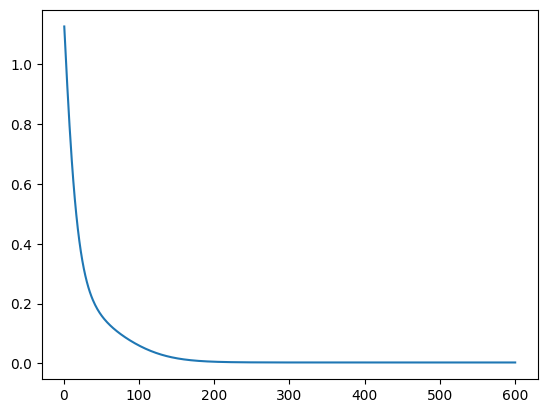

In [46]:
loss_history = []

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # 1. a) Alte Gewichte aus dem Modell extrahieren
        W_s_tf = model.trainable_weights[0]
        b_s_tf = model.trainable_weights[1]

        # 1. b) Forward Pass mit alten Gewichten berechnen
        y_pred_manual = forward_TF(t_scaled_tf, W_s_tf, b_s_tf, A_s, C_s)

        # 2. Loss berechnen
        loss = mse_loss(y_scaled_tf, y_pred_manual)

    # 3. Gradienten berechnen
    gradients = tape.gradient(loss, model.trainable_weights)

    # 4. Gradienten anwenden
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    loss_history.append(loss.numpy())

    # f. (Optional) Ausgabe alle 20 Epochen
    if (epoch+1) % 20 == 0:
        print(f'Epoche {epoch+1}, Loss: {loss.numpy()}')

# Gewichte aus dem Modell extrahieren
W_s_tf, b_s_tf = model.get_weights()
print(f"W (TensorFlow): {W_s_tf[0][0]}, b (TensorFlow): {b_s_tf[0]}")

plt.plot(np.linspace(1, epochs, epochs), loss_history)
plt.show()

In [47]:
# Rücktransformation der gelernten Parameter
W_tf = W_s_tf / std_t
b_tf = b_s_tf - W_tf * mean_t 

print(W_tf[0], b_tf[0]/np.pi)

[0.52801166] [-0.61392453]


Wie wir sehen bekommen wir mit dem TensorFlow-Ansatz ziemlich genau die gleichen Parameterwerte und auch der Verlustwert sinkt auf ähnliche Werte wie bei der manuellen Implementierung:

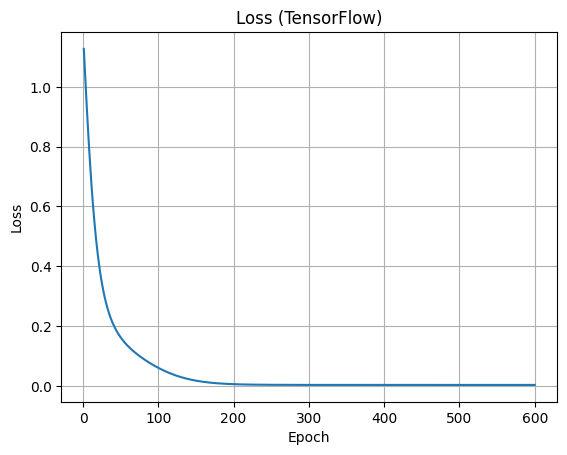

In [48]:
plt.plot(np.linspace(1, epochs, epochs), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (TensorFlow)")
plt.grid()
plt.show()

### Vergleich der Ergebnisse

Nachdem beide Modelle vollständig trainiert sind, können wir ihre Vorhersagen nun vergleichen. Wir sehen im folgenden Plot, dass sich die Ergebnisse kaum unterscheiden. Allerdings war der Weg dorthin unterschiedlich lang.

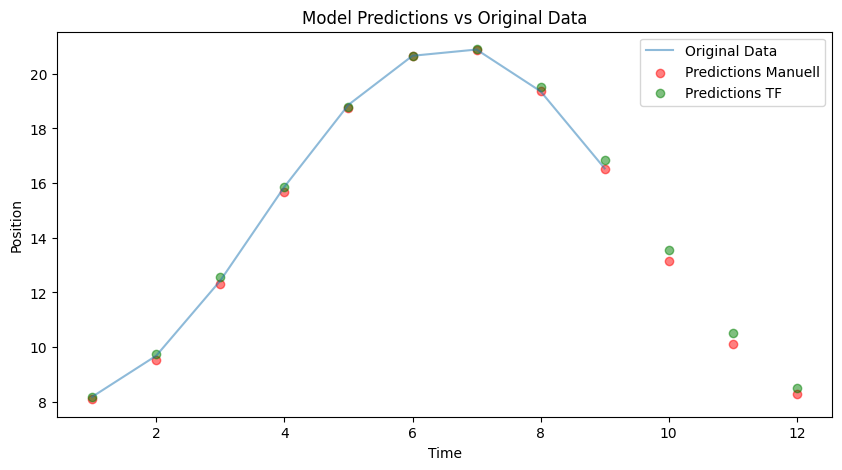

In [49]:
# Plot der Vorhersagen
frame = df.groupby('Time')['Position'].mean()
t, y = frame.index, frame.values

plt.figure(figsize=(10, 5))
plt.plot(t,y, label='Original Data', alpha=0.5)
plt.scatter(np.linspace(1, 12, 12), forward_TF(tf.convert_to_tensor(np.linspace(1, 12, 12), dtype=tf.float32), W_tf, b_tf, A, C), label='Predictions Manuell', color='red', alpha=0.5)
plt.scatter(np.linspace(1, 12, 12), forward_SLP(W, b, np.linspace(1, 12, 12), A, C), label='Predictions TF', color='green', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Model Predictions vs Original Data')
plt.legend()
plt.show()

## Zusammenfassung
In diesem Notebook hast du zwei grundlegend unterschiedliche Ansätze kennengelernt, ein Single-Layer Perceptron (SLP) zu trainieren – einmal vollständig manuell, einmal mithilfe von TensorFlow. Dabei wurde vermittelt, wie neuronale Netze lernen und wie viel Aufwand moderne Libraries abnehmen können.

### Manuelle Implementierung

Wir haben die einzelnen Komponenten eines neuronalen Netzes selbst programmiert:
  - den Forward Pass mit einer eigenen Aktivierungsfunktion (`sin`)
  - den Loss (mittlere quadratische Abweichung)
  - die analytische Berechnung der Gradienten
  - das Parameterupdate mithilfe von Gradient Descent

Dabei ist vorteilhaft, dass man sehr genau versteht, was passiert. Allerdings wird die Implementierung jeder einzelnen Funktion und vor allem die Herleitung der Gradienten irgendwann sehr aufwändig.

### TensorFlow-Implementierung

TensorFlow nimmt uns viele Schritte ab:
  - Das Modell wird über ein `Sequential`-Objekt mit einem `Dense`-Layer aufgebaut
  - Die Gewichte und der Bias werden automatisch verwaltet
  - Das `GradientTape` übernimmt die komplette Ableitung des Loss
  - Mit nur wenigen Zeilen Code erhalten wir ein trainierbares Modell

### Vergleich beider Ansätze

| Aspekt                      | Manuell                                    | TensorFlow                              |
|----------------------------|--------------------------------------------|------------------------------------------|
| Modellarchitektur          | selbst geschrieben                         | über `Sequential` + `Dense` definiert   |
| Aktivierungsfunktion       | selbst geschrieben                         | selbst geschrieben (optional in `Dense` nutzbar)           |
| Forward Pass               | selbst geschrieben                         | selbst geschrieben (für Sinus nötig), sonst automatisch    |
| Loss                       | selbst definiert                           | bereits vordefiniert verfügbar          |
| Gradientenberechnung       | analytisch per Hand                        | automatisch via `GradientTape`          |
| Parameter-Update           | eigene Regel                               | `optimizer.apply_gradients()`           |
| Transparenz                | sehr hoch                                  | abstrahiert, aber kontrollierbar         |
| Codeumfang                 | länger und fehleranfälliger                    | kompakter und wartbar                     |

### Fazit

Beide Ansätze haben ihre Berechtigung:

- Die manuelle Implementierung hilft dabei, die mathematischen Grundlagen und die innere Logik neuronaler Netze wirklich zu verstehen.
- Die TensorFlow-Version zeigt auf, wie diese Prinzipien in der Praxis skalierbar, effizient und flexibel umgesetzt werden können.

>  Wenn du in Zukunft komplexere Architekturen trainieren willst, ist der Griff zu TensorFlow oder PyTorch unverzichtbar.  
>  Doch das Wissen, was unter der Haube passiert, ist entscheidend – und genau das haben wir hier erarbeitet.
